# How to optimize the initial layout

Here, we show how to optimize the initial mapping using the `SATMapper` class. This class implements the initial mapping framework developped by A. Matsuo *et al.* published in [IEICE Trans. Fundam. Electron. Commun. Comput. Sci. (2023) 2022EAP1159](https://doi.org/10.1587/transfun.2022EAP1159). The idea is to find a placement of the decision variables to qubits that minimizes the number of SWAP layers that are needed.
Figure (a) below shows a network of $R_{ZZ}$ gates that can be interpreted as a graph in (b). We refer to the graph in (b) as the *problem graph*. Figure (c) shows a line coupling map as the black edges in a graph $C(0)$. The red edges correspond to the additional qubit connections that the first layer of SWAP gates, shown in red in (d), implement. This defines a new graph $C(1)$. The blue edges in (c) are the additional qubit connections that the second layer of SWAP gates, shown in blue in (d), implement. This defines a new graph $C(2)$.

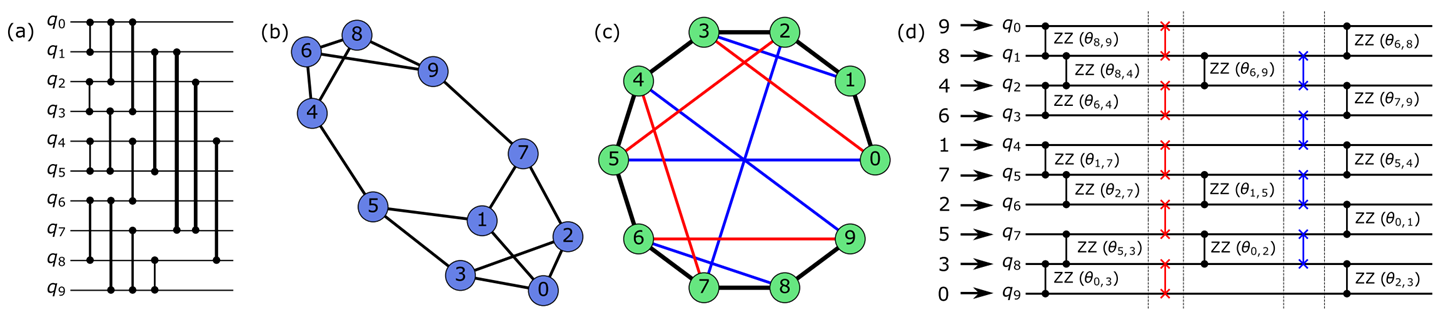

Therefore, for a given number of SWAP layers $\ell\in\mathbb{N}$ we seek a permutation of the nodes of the problem graph, such that it can be embeded by the coupling map $C(\ell)$ produced by the $\ell$ swap layers. This problem can be formulate as a boolean SAT problem and the permutation is the initial mapping we are looking for. Crucially, such permutations may not exist if $\ell$ is too small. By contrast, if $\ell$ is large enough$-$for example, $\ell=n-2$ for a line swap strategy$-$then the problem is trivial to solve since the coupling map may be fully connected.

The `SATMapper` in this repository attempts to find the smallest possible $\ell$ such that there exists a valid initial mapping. The SAT mapper does this via a binary search over $\ell$ and solves a SAT problem for each value of $\ell$. Importantly, there are values of $\ell$ for which the underlying SAT problems are very hard to solve. Therefore, the `SATmapper` has a built in timeout and will assume that it cannot find a valid initial mapping for a given $\ell$ if the timeout is exceeded. We now show the impact that the `SATMapper` can have on the circuit depth.


### 1. Problem setup

We first start with a random regular graph.

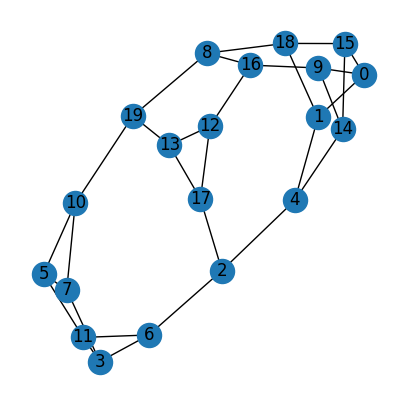

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

graph = nx.random_regular_graph(n=20, d=3, seed=0)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
nx.draw(graph, with_labels=True, ax=ax)

This graph has 20 nodes and 30 edges, and it can be encoded in 20 qubits. We convert it to a cost-operator format and build a QAOA circuit with and without the SAT mapping.

In [2]:
from qiskit.quantum_info import SparsePauliOp
from qopt_best_practices.utils import build_max_cut_paulis

cost_op = SparsePauliOp.from_list(build_max_cut_paulis(graph))

We will construct the circuit for a line of qubits with and without the initial mapping. For this, we setup a backend built from a line coupling map to which we will transpile to.

In [3]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import CouplingMap

cmap = CouplingMap([(idx, idx + 1) for idx in range(graph.order()-1)])
backend = GenericBackendV2(
    num_qubits=20, coupling_map=cmap, basis_gates=["x", "sx", "rzz", "id", "rz"], seed=0
)

### 2. Transpilation without the `SATMapper`

We setup a line swap strategy.

In [4]:
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import SwapStrategy

swap_strategy = SwapStrategy.from_line([i for i in range(graph.order())])

For the transpilation, we will use the pre-init section of the prset QAOA pass manager wihtout the gate synthesis and simplification. This allows us to stop the transpilation at the level of the SWAP routing so that we can clearly see the impact of the SAT mapping on the circuit depth.

In [5]:
from qiskit.transpiler import PassManager
from qopt_best_practices.transpilation.annotated_transpilation_passes import (
    AnnotatedPrepareCostLayer,
    AnnotatedCommuting2qGateRouter,
    AnnotatedSwapToFinalMapping,
    UnrollBoxes,
)

pre_init = PassManager([AnnotatedPrepareCostLayer(), AnnotatedCommuting2qGateRouter(swap_strategy), AnnotatedSwapToFinalMapping(), UnrollBoxes()])

As can be seen below, the circuit is very deep.

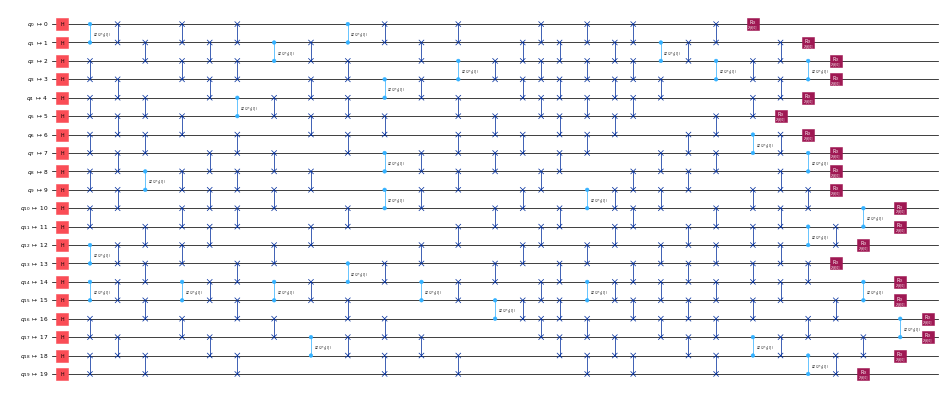

In [6]:
from qopt_best_practices.circuit_library import annotated_qaoa_ansatz

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ansatz = pre_init.run(annotated_qaoa_ansatz(cost_op, reps=1))
ansatz.draw("mpl", fold=False, ax=ax)

### 2. Find an intial mapping with the `SATMapper`

We now show how to find the initial mapping with the SATMapper. This requires the graph or cost operator to remap as well as the SWAP strategy.

In [7]:
from qopt_best_practices.sat_mapping import SATMapper

sm = SATMapper(timeout=10)
sat_cost_op, sat_map, min_sat_layers = sm.remap_graph_with_sat(graph=cost_op, swap_strategy=swap_strategy)

print("Map from old to new edges: ", sat_map)
print("Min SAT layers:", min_sat_layers)

Map from old to new edges:  {0: 6, 1: 11, 2: 13, 3: 3, 4: 12, 5: 0, 6: 2, 7: 1, 8: 9, 9: 17, 10: 7, 11: 5, 12: 18, 13: 19, 14: 16, 15: 15, 16: 10, 17: 14, 18: 4, 19: 8}
Min SAT layers: 5


As can be seen, the resulting QAOA circuit with the SAT remapped cost operator is significantly shallower than the original one.

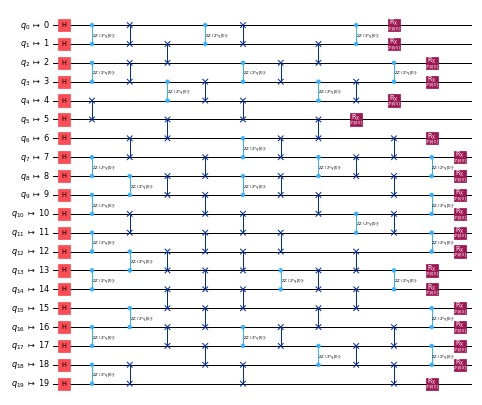

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sat_ansatz = pre_init.run(annotated_qaoa_ansatz(sat_cost_op, reps=1))
sat_ansatz.draw("mpl", fold=False, ax=ax)

### 3. Summary

The circuit depth and gate count of the circuit with and without the SAT mapper are given below. The SAT mapper has significantly reduced the umber of SWAP gates that we need to perform.

In [9]:
print("Two-qubit gate depth\nwithout SAT:", ansatz.depth(lambda x: len(x.qubits) > 1))
print("with SAT", sat_ansatz.depth(lambda x: len(x.qubits) > 1))
print("\nGate count\nwithout SAT:", ansatz.count_ops())
print("with SAT", sat_ansatz.count_ops())

Two-qubit gate depth
without SAT: 28
with SAT 10

Gate count
without SAT: OrderedDict({'swap': 169, 'rzz': 30, 'h': 20, 'rx': 20})
with SAT OrderedDict({'swap': 45, 'rzz': 30, 'h': 20, 'rx': 20})
